In [4]:
import numpy as np
from pyscf import gto, scf, mcscf
import jax
from jax import random
import matplotlib.pyplot as plt

from qmc.pyscftools import orbital_evaluator_from_pyscf
from qmc.setting import initialize_calculation, determine_complex_settings
from qmc.mc import limdrift
from qmc.orbitals import *
from qmc.determinants import *
from qmc.extract import *
from qmc.mc import vmc, optimize_mo_coeff, orthogonalize_orbitals_s_based
from qmc.plot import *

import pyscf
import pyqmc.api as pyq
import warnings

from qmc.parameter_update import (
    # 메인 최적화 함수들
    optimize_mo_coeff_improved,
    quick_fisher_optimization,
    compare_optimization_methods,
    conservative_optimization,
    
    # 개별 업데이트 함수들
    fisher_information_update,
    gradient_descent_update,
    compute_fisher_information_matrix,
    compute_energy_gradients,
    
    # 분석 함수들
    analyze_optimization_stability,
    print_optimization_summary,
    get_safe_optimization_params,
    
    # 테스트 함수
    test_parameter_update
)

jax.config.update("jax_enable_x64", True)
warnings.filterwarnings('ignore')



In [6]:

mol = pyscf.gto.M(
    atom="""
         H 0. 0. 0.;
         H 0. 0. 2.0;
         """,
    ecp="ccecp",
    basis="ccecpccpvdz",
    unit="bohr",
    verbose = 0)

mf = pyscf.scf.UHF(mol)
mf.kernel()

Fock_energy = -1.0905378313306202

key = jax.random.PRNGKey(seed=42)

nconfig, seed = 100, 42

coords, max_orb, det_coeff, det_map, mo_coeff, occup_hash, occup, _nelec, nelec = \
    initialize_calculation(mol, nconfig, seed)
    
iscomplex, mo_dtype, get_phase = \
    determine_complex_settings(mo_coeff, det_coeff)
coords = jnp.array(coords)
atom_coords = jnp.array(mol.atom_coords())
atom_charges = jnp.array(mol.atom_charges())
overlap_matrix = mol.intor("int1e_ovlp")
overlap_matrix = jnp.array(overlap_matrix) 

aovals, dets, inverse = recompute(mol, coords, mo_coeff, _nelec, occup_hash)
mo_coeff_grad = parameter_gradient(coords, aovals, dets, det_coeff, mo_coeff, det_map, occup_hash, _nelec, inverse)["mo_coeff_alpha"]
print(mo_coeff_grad.shape)

(100, 10, 1)


In [4]:
results = optimize_mo_coeff(mol, coords, mo_coeff, overlap_matrix, det_coeff, det_map, _nelec, occup_hash,
                            atom_charges, atom_coords, key, get_phase, n_iterations=300, learning_rate=0.01)

/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lea

Iteration 1, Energy: -1.064686, Min Energy: -1.064686 (Iteration 1)


/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/qmc/lib/python3.10/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lea

Iteration 2, Energy: -1.066986, Min Energy: -1.066986 (Iteration 2)
Iteration 3, Energy: -1.075671, Min Energy: -1.075671 (Iteration 3)
Iteration 4, Energy: -1.082827, Min Energy: -1.082827 (Iteration 4)
Iteration 5, Energy: -1.079811, Min Energy: -1.082827 (Iteration 4)
Iteration 6, Energy: -1.073659, Min Energy: -1.082827 (Iteration 4)
Iteration 7, Energy: -1.027752, Min Energy: -1.082827 (Iteration 4)
Iteration 8, Energy: -0.978017, Min Energy: -1.082827 (Iteration 4)
Iteration 9, Energy: -1.009433, Min Energy: -1.082827 (Iteration 4)
Iteration 10, Energy: -1.040776, Min Energy: -1.082827 (Iteration 4)
Iteration 11, Energy: -1.049940, Min Energy: -1.082827 (Iteration 4)
Iteration 12, Energy: -1.058212, Min Energy: -1.082827 (Iteration 4)
Iteration 13, Energy: -1.025918, Min Energy: -1.082827 (Iteration 4)
Iteration 14, Energy: -1.035528, Min Energy: -1.082827 (Iteration 4)
Iteration 15, Energy: -1.028729, Min Energy: -1.082827 (Iteration 4)
Iteration 16, Energy: -0.960178, Min Energ

In [17]:
optimal_mocoeff = results["optimized_mo_coeff"]
optimal_coords = results["min_energy_configs"]
min_energy = results["min_energy"]
energies = results["energies"]

print(optimal_mocoeff[0].shape)
print(optimal_coords.shape)
print(min_energy)



(10, 1)
(100, 2, 3)
-1.1861235418043792


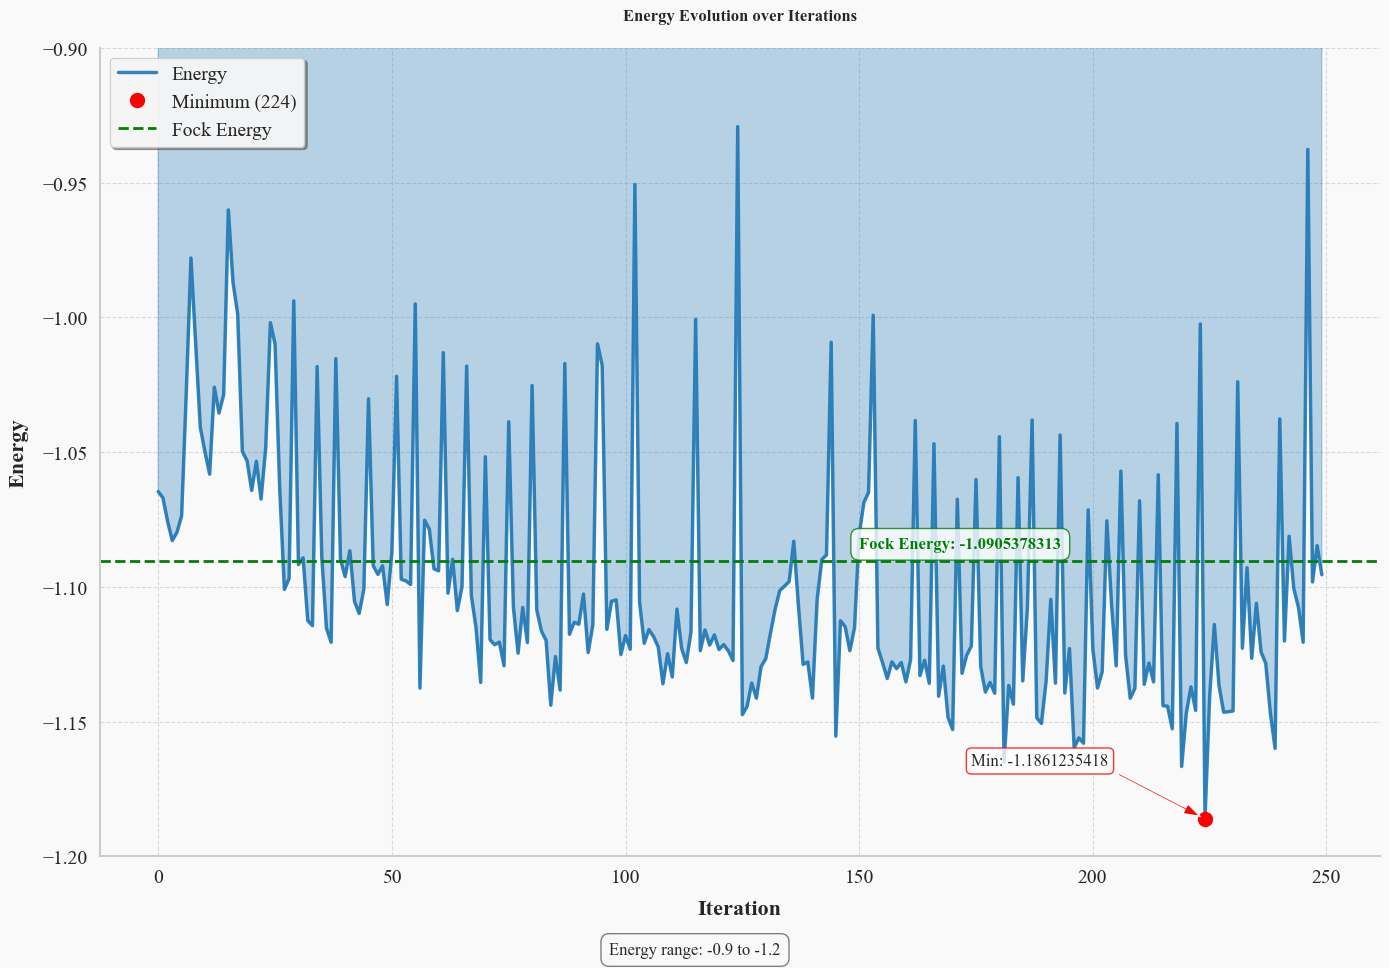

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import stats

# Setting a more aesthetic style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

# Create figure with a pleasant background color
fig, ax = plt.subplots(figsize=(14, 10), facecolor='#f9f9f9')
ax.set_facecolor('#f9f9f9')

# Plot with a more appealing color and style
line, = ax.plot(energies[:250], linewidth=2.5, color='#1f77b4', 
               alpha=0.9, label='Energy')

# Add a subtle gradient effect
ax.fill_between(range(250), energies[:250], alpha=0.3, color='#1f77b4')

# Set y-axis range from -1.2 to -0.9 as requested
ax.set_ylim(-1.2, -0.9)

# Improve grid appearance
ax.grid(True, linestyle='--', alpha=0.7)

# Enhance axis appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Set labels with better appearance
ax.set_xlabel('Iteration', fontweight='bold', labelpad=10)
ax.set_ylabel('Energy', fontweight='bold', labelpad=10)
ax.set_title('Energy Evolution over Iterations', fontweight='bold', pad=20)

# Add markers at key points (e.g., min value)
min_idx = np.argmin(energies[:250])
ax.plot(min_idx, energies[min_idx], 'ro', markersize=10, label=f'Minimum ({min_idx})')

# Add Fock energy reference line
Fock_energy = -1.0905378313306202
ax.axhline(y=Fock_energy, color='green', linestyle='--', linewidth=2, label='Fock Energy')

# Calculate better positions for annotations
x_max = 250
x_annotation = x_max * 0.6  # Position at 60% of x-axis

# Add text annotation for Fock energy - positioned at the right side
ax.text(x_annotation, Fock_energy + 0.005, f'Fock Energy: {Fock_energy:.10f}', 
        fontsize=12, color='green', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='green', boxstyle='round,pad=0.5'))

# Better position for legend - upper left to avoid overlap with annotations
ax.legend(frameon=True, framealpha=0.9, loc='upper left', fancybox=True, shadow=True)

# Add annotations for minimum - properly positioned
min_value = energies[min_idx]
y_offset = 0.02 if min_value < Fock_energy else -0.02  # Adjust based on position relative to Fock energy
xytext_position = (min_idx + 30, min_value + y_offset)

# Check if annotation would be too close to the right edge
if xytext_position[0] > x_max * 0.85:
    xytext_position = (min_idx - 50, min_value + y_offset)  # Move to the left instead

ax.annotate(f'Min: {min_value:.10f}', 
            xy=(min_idx, min_value),
            xytext=xytext_position,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.3'),
            arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8))

# Improve tick appearance
ax.tick_params(axis='both', width=1.5, length=5)

# Add a title at the top of the graph with info about data range
plt.figtext(0.5, 0.01, 'Energy range: -0.9 to -1.2', ha='center', 
           fontsize=12, bbox=dict(facecolor='#f9f9f9', edgecolor='gray', boxstyle='round,pad=0.5'))

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the bottom text
plt.savefig("Energy.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
print("\n=== Detailed Control ===")
results_detailed = optimize_mo_coeff_improved(
    mol, coords, mo_coeff, overlap_matrix, det_coeff, det_map,
    _nelec, occup_hash, atom_charges, atom_coords, key, get_phase,
    time_step = 2.114,
    method="fisher",
    n_iterations=100,
    initial_learning_rate=0.01,
    vmc_blocks=10,
    vmc_steps_per_block=100,
    system_size="small",
    verbose=True
)

# 4. 결과 분석
print("\n=== Analysis ===")
analysis = analyze_optimization_stability(results_detailed, plot=True)
print_optimization_summary(results_detailed)

=== Quick Fisher Optimization ===

=== MO Coefficient Optimization ===
Method: FISHER
System size: small
Iterations: 30
VMC sampling: 5 blocks × 30 steps
Initial learning rate: 0.003000
Regularization: 1e-05
--------------------------------------------------
Iter   1: E = -1.09444997 (Best: -1.09444997), |∇| = 0.151439, LR = 0.003000, Acc = 0.932
Iter   2: E = -1.09443347 (Best: -1.09444997), |∇| = 0.155371, LR = 0.003000, Acc = 0.932
Iter   3: E = -1.09437592 (Best: -1.09444997), |∇| = 0.154422, LR = 0.003000, Acc = 0.932
Iter   4: E = -1.09434764 (Best: -1.09444997), |∇| = 0.153501, LR = 0.002400, Acc = 0.932
Iter   5: E = -1.09430812 (Best: -1.09444997), |∇| = 0.152625, LR = 0.001920, Acc = 0.932
Iter   6: E = -1.09419974 (Best: -1.09444997), |∇| = 0.144802, LR = 0.001536, Acc = 0.932
Iter   7: E = -1.09418152 (Best: -1.09444997), |∇| = 0.144318, LR = 0.001229, Acc = 0.932
Iter   8: E = -1.09416753 (Best: -1.09444997), |∇| = 0.143950, LR = 0.000983, Acc = 0.932
Iter   9: E = -1.0941

KeyboardInterrupt: 